# One shot learning (UNFINISHED, expected to be finished before September 8th 2016).

Imagine we have a bunch of classes, say 10 classes, and we'd like to perform a classification task. However, we only have a good amount of data for 7 classes out of 10. For the other 3 classes, there's only a very limited number of examples (say 1 or 2 examples for instance). The idea of *one shot learning* is to train a network on the classes for which we have a lot of data and use this trained network to classify examples from the classes for which it wasn't trained on. Here, we mostly follow the approach described in *Siamese Neural Networks for One-shot Image Recognition* by Koch et al.

We use a siamese architecture that we train on the MNIST data set. More specifically, we only train the netowk on digits from 0 to 6. The network will take two images and answer the following question: **do the two inputs belong to the same class?** After the training has been completed, we try to classify the digits 7, 8 and 9 by comparing the testing examples to the very limited labeled data we have for these classes.

For more details on *siamese architecture*, I refer the interested reader to the implementation of a siamese network in the notebook **siamese**.

In [3]:
import sys
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, '../data_processing/')
from siamese_data import MNIST # load the data and process it
%matplotlib inline

We load the data.

In [4]:
data = MNIST()

## Learning a similarity metric with a siamese network

We are going to implement a siamese architecture similar to the one described in the **siamese notebook**, but we are going to use convolutional neural networks instead of LSTM.

In [5]:
n_classes = 2 # two possible classes, either `same` of `different`

In [6]:
x1 = tf.placeholder(tf.float32, shape=[None, 28, 28, 1]) # placeholder for the first network (image 1)
x2 = tf.placeholder(tf.float32, shape=[None, 28, 28, 1]) # placeholder for the second network (image 2)

# placeholder for the label. `[1, 0]` for `same` and `[0, 1]` for `different`.
y = tf.placeholder(tf.int64, shape=[None])

# placeholder for dropout (we could use different dropouts for different part of the architecture)
keep_prob = tf.placeholder(tf.float32)

In [7]:
def conv_2d(x, kernel_shape, stride, padding='SAME'):
    strides = [1, stride, stride, 1]
    K = tf.get_variable(name='weights', shape=kernel_shape, initializer=tf.random_normal_initializer())
    b = tf.get_variable(name='biases', shape=kernel_shape[-1], initializer=tf.constant_initializer(0.))
    conv = tf.nn.conv2d(x, K, strides=strides, padding=padding)
    conv += b
    print(conv.get_shape())
    return tf.nn.relu6(conv, name='relu6')

def maxpool(x, pool, stride, padding='SAME'):
    ksize = [1, pool, pool, 1]
    strides = [1, stride, stride, 1]
    maxpool = tf.nn.max_pool(x, ksize, strides, padding=padding, name='maxpool')
    print(maxpool.get_shape())
    return maxpool


def convnet(x):
    with tf.variable_scope('conv1') as scp: # (None, 28, 28, 1)
        net = conv_2d(x, [5, 5, 1, 32], stride=1) # (None, 28, 28, 32)
        net = maxpool(net, 2, 2, padding='VALID') # (None, 14, 14, 32)
    
    with tf.variable_scope('conv2') as scp:
        net = conv_2d(net, [3, 3, 32, 32], stride=1) # (None, 14, 14, 32)
        net = maxpool(net, 2, 2) # (None, 7, 7, 32)
        
    #with tf.variable_scope('conv3') as scp:
    #    net = conv_2d(net, [5, 5, 64, 64], stride=1) # (None, 6, 6, 64)
    #    net = maxpool(net, 2, 2) # (None, 3, 3, 64)
        
    with tf.variable_scope('fully_connected') as scp:
        W = tf.get_variable('weights', shape=[7*7*32, 512], initializer=tf.random_normal_initializer())
        b = tf.get_variable('biases', shape=[512], initializer=tf.constant_initializer(0.))
        net = tf.reshape(net, shape=[-1, 7*7*32])
        net = tf.matmul(net, W) + b # (None, 512)
        print(net.get_shape())    
    return net

In [8]:
with tf.variable_scope('siamese_network') as scope:
    with tf.name_scope('convnet_1'):
        convnet1 = convnet(x1)
    with tf.name_scope('convnet_2'):
        scope.reuse_variables() # tied weights (reuse the weights from `Bi_LSTM_1` for `Bi_LSTM_2`)
        convnet2 = convnet(x2)

with tf.name_scope('output') as scp:
    net_difference = tf.abs(convnet1 - convnet2)
    W = tf.get_variable('weights_' + scp, shape=[512, n_classes], initializer=tf.random_normal_initializer())
    b = tf.get_variable('biases_' + scp, shape=[n_classes], initializer=tf.constant_initializer(0.))
    logits = tf.matmul(net_difference, W) + b # (None, 2)
    print(logits.get_shape())

(?, 28, 28, 32)
(?, 14, 14, 32)
(?, 14, 14, 32)
(?, 7, 7, 32)
(?, 512)
(?, 28, 28, 32)
(?, 14, 14, 32)
(?, 14, 14, 32)
(?, 7, 7, 32)
(?, 512)
(?, 2)


In [9]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.AdamOptimizer().minimize(loss)

correct_pred = tf.equal(tf.argmax(logits, 1), y) 
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [ ]:
init = tf.initialize_all_variables()

max_iter = 10000 # maximum number of iterations for training
batch_train = 128 # batch size for training
batch_test = 512 # batch size for testing
display = 50 # display the training loss and accuracy every `display` step
n_test = 100 # test the network every `n_test` step

n_snapshot = 1000 # save the weights every `n_snapshot` step
checkpoint_dir = 'models/one_shot_learning/'
saver = tf.train.Saver() # to save the trained model

with tf.Session() as sess:
    sess.run(init) # initialize all variables
    print('Network training begins.')
    for i in range(1, max_iter + 1):
        # We retrieve a batch of data from the training set (digits between 0 and 6)
        batch_x1, batch_x2, batch_y = data.get_next_batch(batch_train, phase='train', one_shot=True)
        batch_x1, batch_x2 = np.expand_dims(batch_x1, axis=3), np.expand_dims(batch_x2, axis=3)
        # We feed the data to the network for training
        feed_dict = {x1: batch_x1, x2: batch_x2, y: batch_y, keep_prob: .9}
        _, loss_, accuracy_ = sess.run([optimizer, loss, accuracy], feed_dict=feed_dict)
        
        if i % display == 0:
            print('step %i, training loss: %.5f, training accuracy: %.3f' % (i, loss_, accuracy_))
        
        # Testing the network
        if i % n_test == 0:
            # Retrieving data from the test set
            batch_x1, batch_x2, batch_y = data.get_next_batch(batch_test, phase='test', one_shot=True)
            batch_x1, batch_x2 = np.expand_dims(batch_x1, axis=3), np.expand_dims(batch_x2, axis=3)
            feed_dict = {x1: batch_x1, x2: batch_x2, y: batch_y, keep_prob: 1.0}
            accuracy_test = sess.run(accuracy, feed_dict=feed_dict)
            print('testing step %i, accuracy %.3f' % (i, accuracy_test))
        
        # We save a snapshot of the weights
        if i % n_snapshot == 0:
            save_path = saver.save(sess, os.path.join(checkpoint_dir,'snapshot_') + str(i) + '.ckpt')
            print('Snapshot saved in file: %s' % save_path)

    print('********************************')
    print('Training finished.')

Network training begins.
step 50, training loss: 567.46625, training accuracy: 0.594
step 100, training loss: 460.99860, training accuracy: 0.648
testing step 100, accuracy 0.598
step 150, training loss: 555.39789, training accuracy: 0.609
step 200, training loss: 376.61969, training accuracy: 0.711
testing step 200, accuracy 0.660
step 250, training loss: 422.08929, training accuracy: 0.711
step 300, training loss: 312.55170, training accuracy: 0.773
testing step 300, accuracy 0.721
step 350, training loss: 369.71555, training accuracy: 0.688
step 400, training loss: 248.51530, training accuracy: 0.797
testing step 400, accuracy 0.742
step 450, training loss: 254.05536, training accuracy: 0.773
step 500, training loss: 317.99246, training accuracy: 0.727
testing step 500, accuracy 0.768
step 550, training loss: 122.08199, training accuracy: 0.867
step 600, training loss: 244.96976, training accuracy: 0.758
testing step 600, accuracy 0.787
step 650, training loss: 188.65747, training a

In [9]:
print batch_x1.shape
print np.expand_dims(batch_x1, axis=3).shape

(512, 28, 28, 1)
(512, 28, 28, 1, 1)


## One shot learning: using the pretrained similarity metric on new classes

We now want to see how the network performs on images from unseen classes, i.e. sevens, eights and nines.

Following the approach described by Koch et al., we chose 10 images ($i_0, i_1,...,i_9$), one per class. We then classify an image by comparing it pairwise with the images $i_0,...,i_9$.

But first, let's chose 10 reference images.

In [10]:
one_example_per_class = []
for digit in data.digits:
    one_example_per_class.append(getattr(data, digit)[np.random.randint(len(getattr(data, digit)))])

Below, we display the 10 images we use ($i_0,...,i_9$) as a benchmark for pairwise comparisons.

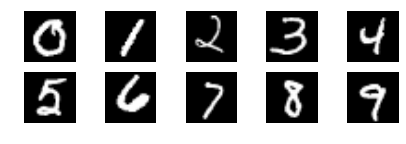

In [11]:
fig = plt.figure(figsize=(7,2))
for i in range(1, 11):
    a = fig.add_subplot(2, 5, i)
    a.axis('off')
    image = one_example_per_class[i - 1].reshape((28, 28)) # reshape the image from (784) to (28, 28).
    a.imshow(image, cmap='Greys_r');

We retrieve the model trained above, and we classify images of 7, 8 and 9 by comparing them with the benchmark images $i_0,...,i_9$. We report the accuracy of the classifcation on the *unseen* classes and on the *seen* classes.

In [16]:
def reshape_input(image):
    """
    Takes a `numpy array` of shape (784) and reshape it
    into a `numpy array` of shape (1, 28, 28).
    """
    image = np.expand_dims(image.reshape((28,28)), axis=0)
    return np.expand_dims(image, axis=3)

def reshape_label(label):
    """
    Argss:
        label: a list of two elements.
    """
    if label[0] == label[1]:
        return np.expand_dims(np.asarray(1),axis=0)
    else:
        return np.expand_dims(np.asarray(0),axis=0)

In [24]:
def compare_two_digits(digit1, digit2, label1, label2, sess):
    true_y = 'different'
    if label1 == label2:
        true_y = 'same'
    label = reshape_label([label1, label2])
    feed_dict = {x1: digit1, x2: digit2, y: label, keep_prob: 1.0}
    logits_, accuracy_test = sess.run([logits, accuracy], feed_dict=feed_dict)
    predicted_y = 'different'
    if np.argmax(logits_[0]) == 1:
         predicted_y = 'same'
    return true_y, predicted_y

In [18]:
one_example_per_class = [reshape_input(x) for x in one_example_per_class]

In [42]:
checkpoint_dir = 'models/one_shot_learning/'
with tf.Session() as sess:
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir=checkpoint_dir)
    saver.restore(sess, latest_checkpoint)
    print('%s was restored.' % latest_checkpoint)
    digit1 = reshape_input(data.eights_test[222])
    for i in range(10):
        digit2 = reshape_input(one_example_per_class[i])
        true_y, predicted_y = compare_two_digits(digit1, digit2, 8, i, sess)
        print 'Comparing %i with 7:' %i, predicted_y

models/one_shot_learning/snapshot_10000.ckpt was restored.
Comparing 0 with 7: different
Comparing 1 with 7: different
Comparing 2 with 7: different
Comparing 3 with 7: different
Comparing 4 with 7: different
Comparing 5 with 7: same
Comparing 6 with 7: different
Comparing 7 with 7: different
Comparing 8 with 7: same
Comparing 9 with 7: same


In [ ]:
a = [[ 2.24756432,  0.03931087]]
a[0]